In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 KB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=hKWYe67p4RJBYnZmNjTj6X1xQ9nrbGCnS0hCOTHTGJM&tc=er1tdfIV5qQigBy5KLu3qvPBVcKXnKItyWDWLTZNdcs&cc=x3m7fpij3KU37Tv50FUlSKQE4-Prw89j8NvMgDKCt6c

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh5SiDsNcg4n2LKLiS-4A7UXMhk0j_m4-A4_bdMDdEZSZLZ8OkBolUg

Successfully saved authorization token.


In [ ]:
import geemap
import datetime
import numpy as np
import math

In [ ]:
basin = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/WeiGan_Basin')
four = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020_the_second_method/four')

In [ ]:
def maskS2clouds(image):
    qa = image.select('QA60');
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
      .And(qa.bitwiseAnd(cirrusBitMask).eq(0));
    return image.updateMask(mask);

In [ ]:
# 构建NDVI时间序列
def NDVI_timeMax(start_time,end_time,day_gap,image_number,area):

  def NDVI(image):
    nir = image.select("B8");
    red = image.select("B4");
    ndvi = nir.subtract(red).divide(nir.add(red));
    return image.select().addBands(ndvi);

  image_list = []

  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      NDVI_image = ee.ImageCollection("COPERNICUS/S2_SR")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(NDVI).max().clip(area).rename("NDVI").set("data",s_date)\
                    .set('system:footprint',area.geometry())
      ddiff = ee.Date(s_time).difference(ee.Date(start_time), 'day')
      new_NDVI_image = NDVI_image.addBands(ee.Image(1).toFloat().rename('constant'))\
                                .addBands(ee.Image(ddiff).toFloat().rename('t'))\
                                .addBands(ee.Image(ddiff).pow(ee.Image(2)).toFloat().rename('t2'))\
                                .addBands(ee.Image(ddiff).pow(ee.Image(3)).toFloat().rename('t3'))
      globals()["NDVI_image"+s_date.strftime("%Y%m%d")] = NDVI_image
      image_list.append(globals()["NDVI_image"+s_date.strftime("%Y%m%d")])

  NDVI_col = ee.ImageCollection(image_list)
  NDVI_image = NDVI_col.toBands()
  return NDVI_col,NDVI_image

# 构建NDVI变化时间序列
def NDVI_difference(NDVI_SG_series_col):
  image_list = []
  NDVI_difference_list = []
  NDVI_list = NDVI_SG_series_col.toList(30)
  list_number = len(NDVI_list.getInfo())
  for i in range(list_number-1):
    image_1 = ee.Image(NDVI_list.get(i))
    image_2 = ee.Image(NDVI_list.get(i+1))
    image_difference = image_2.subtract(image_1)  
    globals()["NDVI_difference"+str(i)] = image_difference
    image_list.append(globals()["NDVI_difference"+str(i)])
    NDVI_difference_list.append("NDVI_difference"+'{:0>2d}'.format(i))
  difference_col = ee.ImageCollection(image_list)
  NDVI_differnce_image = difference_col.toBands().rename(NDVI_difference_list)
  return NDVI_differnce_image


# 构建棉花
def BWI_max(start_time,end_time,day_gap,image_number,area):

  def Sentinal_BWI(image):
    image1 = image.select(['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']);
    arrayImage1D = image1.toArray();
    arrayImage2D = arrayImage1D.toArray(1);
    coefficientsSentinel = ee.Array([[1.07, -0.68, -0.24, 0.17, -0.04, -0.39, 0.04, 0.36, -0.01, -0.04]]);
    componentsImage = ee.Image(coefficientsSentinel)\
          .matrixMultiply(arrayImage2D).divide(10000)\
          .arrayProject([0])\
          .arrayFlatten([['BWI']]);
      
    BWI =componentsImage.select("BWI").rename('BWI');
    return image.select().addBands(BWI);

  image_list = []
  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      BWI_image = ee.ImageCollection("COPERNICUS/S2_SR")\
                    .filterDate(s_time, e_time).map(maskS2clouds)\
                    .filterBounds(area).map(Sentinal_BWI).max().clip(area).rename("BWI").set("data",s_date)\
                    .set('system:footprint',area.geometry())
      ddiff = ee.Date(s_time).difference(ee.Date(start_time), 'day')
      new_BWI_image = BWI_image
      globals()["BWI_image"+s_date.strftime("%Y%m%d")] = new_BWI_image
      image_list.append(globals()["BWI_image"+s_date.strftime("%Y%m%d")])

  col = ee.ImageCollection(image_list)
  BWI_image = col.max().rename("BWI")
  return BWI_image

# 构建SAR时间序列
def SAR(start_time,end_time,day_gap,image_number,area):
  def mask_edge(image):
    edge = image.lt(-30.0);
    maskedImage = image.mask().And(edge.Not());
    return image.updateMask(maskedImage);

  SAR_list = []
  image_list = []
  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      SAR_image = ee.ImageCollection('COPERNICUS/S1_GRD')\
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
            .filter(ee.Filter.eq('instrumentMode', 'IW'))\
            .select('VV')\
            .map(mask_edge)\
            .filterDate(s_time, e_time)\
            .mean().clip(area).set("data",s_date).set('system:footprint',area.geometry())
      new_SAR_image = SAR_image
      globals()["SAR_image"+s_date.strftime("%Y%m%d")] = new_SAR_image
      image_list.append(globals()["SAR_image"+s_date.strftime("%Y%m%d")])
      SAR_list.append("SAR"+'{:0>2d}'.format(i))

  col = ee.ImageCollection(image_list)
  SAR_image = col.toBands().rename(SAR_list)
  return SAR_image

# 构建GREEN时间序列
def GREEN(start_time,end_time,day_gap,image_number,area):
  def Sentinal_Green(image):
    green = image.select('B3');
    return image.select().addBands(green);

  image_list = []
  Greem_list=[]
  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      Green_image = ee.ImageCollection("COPERNICUS/S2_SR")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(Sentinal_Green).max().clip(area).rename("Green").set("data",s_date)\
                    .set('system:footprint',area.geometry())
      ddiff = ee.Date(s_time).difference(ee.Date(start_time), 'day')
      new_Green_image = Green_image
      globals()["Green_image"+s_date.strftime("%Y%m%d")] = new_Green_image
      image_list.append(globals()["Green_image"+s_date.strftime("%Y%m%d")])
      Greem_list.append("Green"+'{:0>2d}'.format(i))

  col = ee.ImageCollection(image_list)
  Green_image = col.toBands().rename(Greem_list)
  return Green_image

# 构建红边1时间序列
def Rededge1(start_time,end_time,day_gap,image_number,area):

  def Sentinal_RedEdge1(image):
    RedEdge1 = image.select('B5');
    return image.select().addBands(RedEdge1);

  image_list = []
  RedEdge1_list=[]
  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      RedEdge1_image = ee.ImageCollection("COPERNICUS/S2_SR")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(Sentinal_RedEdge1).max().clip(area).rename("RedEdge1").set("data",s_date)\
                    .set('system:footprint',area.geometry())
      ddiff = ee.Date(s_time).difference(ee.Date(start_time), 'day')
      new_RedEdge1_image = RedEdge1_image
      globals()["RedEdge1_image"+s_date.strftime("%Y%m%d")] = new_RedEdge1_image
      image_list.append(globals()["RedEdge1_image"+s_date.strftime("%Y%m%d")])
      RedEdge1_list.append("RedEdge1"+'{:0>2d}'.format(i))

  col = ee.ImageCollection(image_list)
  RedEdge1_image = col.toBands().rename(RedEdge1_list)
  return RedEdge1_image


# 构建红边2时间序列
def Rededge2(start_time,end_time,day_gap,image_number,area):

  def Sentinal_RedEdge2(image):
    RedEdge2 = image.select('B6');
    return image.select().addBands(RedEdge2);

  image_list = []
  RedEdge2_list=[]
  for i in range(image_number.getInfo()):
      s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
      e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
      s_time = s_date.strftime("%Y-%m-%d");
      e_time = e_date.strftime("%Y-%m-%d");
      RedEdge2_image = ee.ImageCollection("COPERNICUS/S2_SR")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(Sentinal_RedEdge2).max().clip(area).rename("RedEdge2").set("data",s_date)\
                    .set('system:footprint',area.geometry())
      ddiff = ee.Date(s_time).difference(ee.Date(start_time), 'day')
      new_RedEdge2_image = RedEdge2_image
      globals()["RedEdge2_image"+s_date.strftime("%Y%m%d")] = new_RedEdge2_image
      image_list.append(globals()["RedEdge2_image"+s_date.strftime("%Y%m%d")])
      RedEdge2_list.append("RedEdge2"+'{:0>2d}'.format(i))

  col = ee.ImageCollection(image_list)
  RedEdge2_image = col.toBands().rename(RedEdge2_list)
  return RedEdge2_image

In [ ]:
from math import nan
def corn_singal_add(feature):
    return feature.set("landcover","corn_singal").set("index",0);

def corn_wheat_add(feature):
    return feature.set("landcover","corn_wheat").set("index",1);

def cotton_add(feature):
    return feature.set("landcover","cotton").set("index",2);

def wheat_add(feature):
    return feature.set("landcover","wheat").set("index",3);
    
def fruit_add(feature):
    return feature.set("landcover","fruit").set("index",4);

corn_singal = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/corn_singal_pure').map(corn_singal_add).filterBounds(basin)
corn_wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/corn_wheat_pure').map(corn_wheat_add).filterBounds(basin)
cotton = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/cotton_pure').map(cotton_add).filterBounds(basin)
wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/wheat_pure').map(wheat_add).filterBounds(basin)
fruit = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/fruit_pure').map(fruit_add).filterBounds(basin)

# 选择样本
Corn_singal_data = corn_singal.randomColumn('random',seed = 2);
Corn_wheat_data = corn_wheat.randomColumn('random',seed = 2);
Cotton_data = cotton.randomColumn('random',seed = 2);
Fruit_data = fruit.randomColumn('random',seed = 2);
Wheat_data = wheat.randomColumn('random',seed = 2);

# 选择选择训练样本 
Corn_singal_train = Corn_singal_data.filter(ee.Filter.lt('random', 0.7));
Corn_wheat_train = Corn_wheat_data.filter(ee.Filter.lt('random', 0.7));
Cotton_train = Cotton_data.filter(ee.Filter.lt('random', 0.7));
Fruit_train = Fruit_data.filter(ee.Filter.lt('random', 0.7));
Wheat_train = Wheat_data.filter(ee.Filter.lt('random', 0.7));

TRAIN = ee.FeatureCollection(Corn_singal_train).merge(Corn_wheat_train).merge(Cotton_train).merge(Wheat_train).merge(Fruit_train);

    
# 选择验证样本
Corn_singal_test = Corn_singal_data.filter(ee.Filter.gte('random', 0.7));
Corn_wheat_test = Corn_wheat_data.filter(ee.Filter.gte('random', 0.7));
Cotton_test = Cotton_data.filter(ee.Filter.gte('random', 0.7));
Fruit_test = Fruit_data.filter(ee.Filter.gte('random', 0.7));
Wheat_test = Wheat_data.filter(ee.Filter.gte('random', 0.7));


TEST = ee.FeatureCollection(Corn_singal_test).merge(Corn_wheat_test).merge(Cotton_test).merge(Wheat_test).merge(Fruit_test);

def classification(image, out, numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, maxNodes, seed):
  TRAIN_LABEL = image.sampleRegions(TRAIN, scale=10, tileScale=8)
  TEST_LABEL = image.sampleRegions(TEST, scale=10, tileScale=8)
  label = "index"
  bands = image.bandNames()

  trained = ee.Classifier.smileRandomForest(
      numberOfTrees=numberOfTrees,
      variablesPerSplit=variablesPerSplit, 
      minLeafPopulation=minLeafPopulation, 
      bagFraction=bagFraction, 
      maxNodes=maxNodes, 
      seed=seed
  ).train(TRAIN_LABEL, label, bands)

  test = TEST_LABEL.classify(trained);

  confusionMatrix = test.errorMatrix('index', 'classification');
  Matrix = np.array(confusionMatrix.getInfo())
  F1_score = []
  for i in range(len(Matrix)):
    X = sum(Matrix[i])
    x = sum(Matrix[:,i])
    TP = Matrix[i,i]
    P = TP/x
    R = TP/X
    F1 = 2*P*R/(P+R)
    if np.isnan(F1):
      F1_score.append(0);
    else:
      F1_score.append(F1)
  print('Confusion Matrix', confusionMatrix.getInfo())
  print('overall accuracy', confusionMatrix.accuracy().getInfo());
  # 面板上显示总体精度
  print('kappa accuracy', confusionMatrix.kappa().getInfo());
  # 面板上显示kappa值
  print('F1 score', F1_score)
  # result_probility = F1_score
  result_calssification = out.classify(trained)
  trained = trained.setOutputMode("MULTIPROBABILITY")
  result_probility = out.classify(trained).arrayFlatten([['class1', 'class2', 'class3', 'class4', 'class5']])
  return result_calssification,result_probility

In [ ]:
# 设置时间序列开始和时间序列结束的时间点
start_time = "2020-02-01"
end_time = "2020-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()
print(image_number.getInfo())


NDVI = NDVI_timeMax(start_time,end_time,day_gap,image_number,four)
NDVI_col = NDVI[0]
NDVI_image = NDVI[1]
NDVI_differnce_image = NDVI_difference(NDVI_col)
BWI_image = BWI_max(start_time,end_time,day_gap,image_number,four)
SAR_image = SAR(start_time,end_time,day_gap,image_number,four)
image = ee.Image(NDVI_differnce_image).addBands(NDVI_image).addBands(BWI_image).addBands(SAR_image)#.addBands(Green_image)#.addBands(RedEdge1_image).addBands(RedEdge2_image)


result_all_series = classification(image,image,500,2,1,0.85,20,0)
classification_all_series = result_all_series[0]
# accuracy_all_series = result_all_series[1]
accuracy_all_series = result_all_series[1].reduce(reducer=ee.Reducer.max()).rename("max")

20


In [ ]:
# geemap.ee_export_image_to_drive( 
#         image=image.toFloat(), 
#         description="image",
#         region=four.geometry(),
#         scale=500, 
#         crs="EPSG:4326", 
#         maxPixels=1e13 
#       )

In [ ]:
from math import nan
def corn_singal_add(feature):
    return feature.set("landcover","corn_singal").set("index",1);

def corn_wheat_add(feature):
    return feature.set("landcover","corn_wheat").set("index",2);

def cotton_add(feature):
    return feature.set("landcover","cotton").set("index",3);

def wheat_add(feature):
    return feature.set("landcover","wheat").set("index",4);
    
def fruit_add(feature):
    return feature.set("landcover","fruit").set("index",5);

corn_singal = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/corn_singal_pure').map(corn_singal_add).filterBounds(basin)
corn_wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/corn_wheat_pure').map(corn_wheat_add).filterBounds(basin)
cotton = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/cotton_pure').map(cotton_add).filterBounds(basin)
wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/wheat_pure').map(wheat_add).filterBounds(basin)
fruit = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/fruit_pure').map(fruit_add).filterBounds(basin)

# 选择样本
Corn_singal_data = corn_singal.randomColumn('random',seed = 2);
Corn_wheat_data = corn_wheat.randomColumn('random',seed = 2);
Cotton_data = cotton.randomColumn('random',seed = 2);
Fruit_data = fruit.randomColumn('random',seed = 2);
Wheat_data = wheat.randomColumn('random',seed = 2);

# 选择选择训练样本 
Corn_singal_train = Corn_singal_data.filter(ee.Filter.lt('random', 0.7));
Corn_wheat_train = Corn_wheat_data.filter(ee.Filter.lt('random', 0.7));
Cotton_train = Cotton_data.filter(ee.Filter.lt('random', 0.7));
Fruit_train = Fruit_data.filter(ee.Filter.lt('random', 0.7));
Wheat_train = Wheat_data.filter(ee.Filter.lt('random', 0.7));

ValidationTRAIN = ee.FeatureCollection(Corn_singal_train).merge(Corn_wheat_train).merge(Cotton_train).merge(Wheat_train).merge(Fruit_train);
   
# 选择验证样本
Corn_singal_test = Corn_singal_data.filter(ee.Filter.gte('random', 0.7));
Corn_wheat_test = Corn_wheat_data.filter(ee.Filter.gte('random', 0.7));
Cotton_test = Cotton_data.filter(ee.Filter.gte('random', 0.7));
Fruit_test = Fruit_data.filter(ee.Filter.gte('random', 0.7));
Wheat_test = Wheat_data.filter(ee.Filter.gte('random', 0.7));

ValidationTEST = ee.FeatureCollection(Corn_singal_test).merge(Corn_wheat_test).merge(Cotton_test).merge(Wheat_test).merge(Fruit_test);

Validation = classification.sampleRegions(ValidationTEST, scale=10, tileScale=8)
confusionMatrix = Validation.errorMatrix('index', 'sum');
Matrix = np.array(confusionMatrix.getInfo())
F1_score = []
for i in range(len(Matrix)):
  X = sum(Matrix[i])
  x = sum(Matrix[:,i])
  TP = Matrix[i,i]
  P = TP/x
  R = TP/X
  F1 = 2*P*R/(P+R)
  if np.isnan(F1):
    F1_score.append(0);
  else:
    F1_score.append(F1)
print('Confusion Matrix', confusionMatrix.getInfo())
print('overall accuracy', confusionMatrix.accuracy().getInfo());
# 面板上显示总体精度
print('kappa accuracy', confusionMatrix.kappa().getInfo());
# 面板上显示kappa值
print('F1 score', F1_score)

AttributeError: ignored

检查样本数据的分布情况，通过这种方法获取阈值

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
corn_singal = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/corn_singal_pure')
corn_wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/corn_wheat_pure')
cotton = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/cotton_pure')
wheat = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/wheat_pure')
fruit = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/2020point/fruit_pure')

In [ ]:
corn_result = right_rate.sampleRegions(corn_singal, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(corn_result, description="corn", folder="测试", fileNamePrefix=None, fileFormat="csv")
cotton_result = right_rate.sampleRegions(cotton, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(cotton_result, description="cotton", folder="测试", fileNamePrefix=None, fileFormat="csv")
forest_result = right_rate.sampleRegions(fruit, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(forest_result, description="forest", folder="测试", fileNamePrefix=None, fileFormat="csv")
wheat_result = right_rate.sampleRegions(wheat, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(wheat_result, description="wheat", folder="测试", fileNamePrefix=None, fileFormat="csv")
corn_wheat_result = right_rate.sampleRegions(corn_wheat, scale=10, tileScale=8)
geemap.ee_export_vector_to_drive(corn_wheat_result, description="corn_wheat", folder="测试", fileNamePrefix=None, fileFormat="csv")

Exporting corn... Please check the Task Manager from the JavaScript Code Editor.
Exporting cotton... Please check the Task Manager from the JavaScript Code Editor.
Exporting forest... Please check the Task Manager from the JavaScript Code Editor.
Exporting wheat... Please check the Task Manager from the JavaScript Code Editor.
Exporting corn_wheat... Please check the Task Manager from the JavaScript Code Editor.


In [ ]:
import csv
import os, sys
import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/测试"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
# -----------------------------------------------------------
i = 0
# ------------------------------------------------------------
print(CSV_list[i])
filename =os.path.join(csv_origin_dir, CSV_list[i])
data = pd.read_csv(filename)

cottonData = np.array(data['sum'].values)
cottonData

['corn.csv', 'cotton.csv', 'wheat.csv', 'forest.csv', 'corn_wheat.csv']
corn.csv


array([0.59861977, 0.760364  , 0.75568078, 0.74153453, 0.47323648,
       0.77752297, 0.70365238, 0.37438658, 0.3736075 , 0.24437032,
       0.25288386, 0.55324823, 0.63885317, 0.6232428 , 0.22717732,
       0.38844422, 0.3288745 , 0.41621144, 0.32939956, 0.48376049,
       0.72095941, 0.74804364, 0.73031888, 0.64904253, 0.76507363,
       0.65915166, 0.74278393, 0.50784543, 0.66358981, 0.77120217,
       0.60107946, 0.70067893, 0.65665515, 0.76863822, 0.73235555,
       0.66387998, 0.75915513, 0.58678647, 0.71979601, 0.74277122,
       0.78141123, 0.69378074, 0.71814009, 0.62801219, 0.76422639,
       0.78520541, 0.65902941, 0.62203546, 0.6995139 , 0.76470776,
       0.72418169, 0.70060291, 0.73581973, 0.67521304, 0.64013808,
       0.71510729, 0.7000001 , 0.61117641, 0.77458304, 0.77570134,
       0.77175457, 0.74103448, 0.68499737, 0.58090068, 0.71214834,
       0.51080517, 0.77246236, 0.49216386, 0.61738656])

In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/测试"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
# -----------------------------------------------------------
i = 1
# ------------------------------------------------------------
print(CSV_list[i])
filename =os.path.join(csv_origin_dir, CSV_list[i])
data = pd.read_csv(filename)

cornData = np.array(data['sum'].values)
cornData

['corn.csv', 'cotton.csv', 'wheat.csv', 'forest.csv', 'corn_wheat.csv']
cotton.csv


array([0.60977026, 0.77740909, 0.66919537, 0.69082398, 0.63760192,
       0.62199466, 0.74674139, 0.77240685, 0.7210409 , 0.59610662,
       0.72456665, 0.74891742, 0.73708882, 0.75389249, 0.73290839,
       0.45578855, 0.70057762, 0.75477432, 0.60072908, 0.50885673,
       0.71144325, 0.71901615, 0.63676081, 0.59350617, 0.78252355,
       0.61516721, 0.68864912, 0.58646883, 0.35871279, 0.48567266,
       0.39670511, 0.61502113, 0.58461376, 0.72540483, 0.69747168,
       0.63669647, 0.63444151, 0.7188556 , 0.74371127, 0.69931579,
       0.73100133, 0.64443667, 0.64399019, 0.755969  , 0.77691759,
       0.77563969, 0.60731573, 0.56124513, 0.7323148 , 0.71633497,
       0.75372541, 0.65731037, 0.6232226 , 0.72115169, 0.74453617,
       0.6441254 , 0.69444526, 0.76020051, 0.29838258, 0.63166201,
       0.52786752, 0.39800059, 0.75946597, 0.77568527, 0.79974303,
       0.78056687, 0.51263281, 0.7719573 , 0.75244709, 0.63532426,
       0.71346763, 0.54620866, 0.70268943])

In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/测试"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
# -----------------------------------------------------------
i = 2
# ------------------------------------------------------------
print(CSV_list[i])
filename =os.path.join(csv_origin_dir, CSV_list[i])
data = pd.read_csv(filename)

wheatData = np.array(data['sum'].values)
wheatData

['corn.csv', 'cotton.csv', 'wheat.csv', 'forest.csv', 'corn_wheat.csv']
wheat.csv


array([0.33210853, 0.44261315, 0.46049801, 0.45683343, 0.48386705,
       0.50643483, 0.49589941, 0.43610998, 0.4610422 , 0.56560361,
       0.52464703, 0.54862218, 0.51626645, 0.55463554, 0.52181742,
       0.54238198, 0.56500902, 0.52473949, 0.57418193, 0.56676363,
       0.56273541])

In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/测试"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
# -----------------------------------------------------------
i = 3
# ------------------------------------------------------------
print(CSV_list[i])
filename =os.path.join(csv_origin_dir, CSV_list[i])
data = pd.read_csv(filename)

forestData = np.array(data['sum'].values)
forestData

['corn.csv', 'cotton.csv', 'wheat.csv', 'forest.csv', 'corn_wheat.csv']
forest.csv


array([0.22947463, 0.51524413, 0.30224972, 0.48259422, 0.72428815,
       0.41730261, 0.64411777, 0.56189748, 0.30612738, 0.7892175 ,
       0.75361263, 0.2249178 , 0.56350429, 0.3268202 , 0.49803903,
       0.47652808, 0.44853277, 0.65201131, 0.66118149, 0.39792935,
       0.74470599, 0.67196858, 0.72906148, 0.68633338, 0.75439793,
       0.76940506, 0.69814142, 0.76703093, 0.78625785, 0.75783992,
       0.54545392, 0.78546034, 0.66771618, 0.75301791, 0.76511697,
       0.67057893, 0.77574234, 0.77476441, 0.77771031, 0.73101619,
       0.65544846, 0.7206099 , 0.66024299, 0.70516186, 0.67919859,
       0.79684513, 0.73422986, 0.77915572, 0.67201591, 0.75236983,
       0.78820794, 0.71296941, 0.76210461, 0.71407247, 0.74372491,
       0.78717974, 0.7028733 , 0.7833604 , 0.78520538, 0.67868202,
       0.74446912])

In [ ]:
# 打开矢量
csv_origin_dir = r"/content/gdrive/MyDrive/测试"
os.chdir(csv_origin_dir)
CSV_list = glob.glob("*.csv")
print(CSV_list)
# -----------------------------------------------------------
i = 4
# ------------------------------------------------------------
print(CSV_list[i])
filename =os.path.join(csv_origin_dir, CSV_list[i])
data = pd.read_csv(filename)

wheat_cornData = np.array(data['sum'].values)
wheat_cornData

['corn.csv', 'cotton.csv', 'wheat.csv', 'forest.csv', 'corn_wheat.csv']
corn_wheat.csv


array([0.57658421, 0.60129212, 0.67144205, 0.44126408, 0.47338197,
       0.46975558, 0.51962762, 0.58710867, 0.53797037, 0.45663341,
       0.58621868, 0.45492839, 0.63144414, 0.4521708 , 0.52005224,
       0.29157804, 0.34273333, 0.42846181, 0.56757459, 0.32782286,
       0.68499832, 0.52299601, 0.52590448, 0.56195456, 0.50468802,
       0.56489452, 0.47852376, 0.25209547, 0.56080504, 0.26184873,
       0.49248543, 0.59259455, 0.21003938, 0.56933595, 0.36882465,
       0.49872484, 0.49102764, 0.543666  ])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5de0c41490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5de0c41f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5de0c3e450>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5de0c2aa10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5de0c2af50>,
 'means': []}

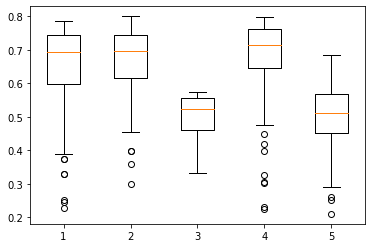

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
all_data = [cottonData,cornData,wheatData,forestData,wheat_cornData]
labels = ["cotton","corn","wheat","forest","wheat_corn"]
fig, ax = plt.subplots()
ax.boxplot(all_data)